From Kodangada Ketan Bopanna 

# Objectives

Recommender Systems Course 2024
The dataset contains user-recipe reviews, including ratings and comments. Your goal is to recommend recipes to users based on their past recipe reviews.

Formal requirements include:
* Implement a content-based recommender system.
* Implement a collaborative filtering model.
* Implement a matrix factorization model.
* Document your model development, evaluation and testing in a notebook file. Please use
* comments as well as markdown cells to describe your thought process and intermediate results.
* Include a short conclusion reviewing your approaches and evaluating their performance.

# Loading and data reading

In [201]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import os
import numpy as np
from collections import Counter

from surprise import Dataset, Reader, KNNBasic, accuracy
from ieseg_recsys import eval, model
from sklearn.model_selection import train_test_split
from scipy import sparse
from surprise import SVD, CoClustering

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, KNNBasic, SVD


# NLP packages
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise import Dataset, Reader, KNNBasic, accuracy, BaselineOnly, SVD, CoClustering
from sklearn.metrics.pairwise import cosine_similarity

In [202]:
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.max_info_columns", 100)

# Train & Metadata

In [203]:
train_path = r"C:\K10\IESEG\Studies\2024\SEM_2\Recommender Systems\Untitled Folder\recommender_systems_2024\train.csv"
metadata_path = r"C:\K10\IESEG\Studies\2024\SEM_2\Recommender Systems\Untitled Folder\recommender_systems_2024\metadata.csv"

In [204]:
train= pd.read_csv(train_path)

In [205]:
metadata = pd.read_csv(metadata_path)

In [206]:
train.date.describe()

count         165226
unique          4448
top       2007-12-30
freq             152
Name: date, dtype: object

In [207]:
metadata.dtypes

name              object
id                object
minutes            int64
contributor_id    object
submitted         object
tags              object
nutrition         object
n_steps            int64
steps             object
description       object
ingredients       object
n_ingredients      int64
dtype: object

In [208]:
user_recipe = pd.merge(metadata, train, left_on="id", right_on='recipe_id', how="right")

In [209]:
# we will use this later
lookup_recipe_id = user_recipe.drop_duplicates(subset=["recipe_id"], keep="last").set_index("recipe_id")

# This is kept aside to be used to lookup the predection IDs

In [210]:
lookup_recipe_id.shape

(62517, 16)

# Collaborative Based

In [211]:
pd.DataFrame({'Type':user_recipe.dtypes, 'Missing':user_recipe.isna().sum(), "Cnt_unique":user_recipe.nunique()})

,Type,Missing,Cnt_unique
name,object,0,62331
id,object,0,62517
minutes,int64,0,561
contributor_id,object,0,12068
submitted,object,0,3675
tags,object,0,59668
nutrition,object,0,62281
n_steps,int64,0,72
steps,object,0,62469
description,object,4585,60253


In [212]:
user_recipe['merged_id'] = user_recipe['id'].astype(str) +'_' +user_recipe['user_id'].astype(str)

In [213]:
# convert timestamp to datetime
user_recipe["date"] = pd.to_datetime(user_recipe["date"], format="mixed")
user_recipe["submitted"] = pd.to_datetime(user_recipe["submitted"], format="mixed")

In [214]:
user_recipe.name.unique()

array(['white bean   green chile pepper soup',
       'devilicious cookie cake delights', 'baked potato toppings', ...,
       'potluck pockets', 'easy microwave hot fudge topping',
       'pot roast with port  stove top'], dtype=object)

In [215]:
print('columns:',user_recipe.columns)
print('shape:', user_recipe.shape)

columns: Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients', 'user_id', 'recipe_id', 'date', 'rating', 'review',
       'merged_id'],
      dtype='object')
shape: (165226, 18)


In [216]:
user_recipe['description'] = user_recipe['description'].fillna('MissingD')     

## Filtering items with 10+ reviews for collaborative filtering models

In [217]:
# filter items with 10+ reviews
review_count = user_recipe["recipe_id"].value_counts()

min_count = 10
recipe_filter = list(review_count[review_count >= min_count].index)


In [218]:
custrecipe_filter = user_recipe[user_recipe['recipe_id'].isin(recipe_filter)].reset_index(drop=True)

print(f"Removed {len(review_count) - (review_count > min_count).sum()} items")

Removed 60445 items


In [219]:
print('user_recipe :',user_recipe.nunique())
print("---------------------------")
print('user_recipe : ',user_recipe.dtypes)
print("---------------------------")
print('custrecipe_filter :',custrecipe_filter.nunique())
print("---------------------------")
print('custrecipe_filter : ',custrecipe_filter.dtypes)

user_recipe : name               62331
id                 62517
minutes              561
contributor_id     12068
submitted           3675
tags               59668
nutrition          62281
n_steps               72
steps              62469
description        60254
ingredients        62353
n_ingredients         35
user_id            11346
recipe_id          62517
date                4448
rating                 6
review            164517
merged_id         165226
dtype: int64
---------------------------
user_recipe :  name                      object
id                        object
minutes                    int64
contributor_id            object
submitted         datetime64[ns]
tags                      object
nutrition                 object
n_steps                    int64
steps                     object
description               object
ingredients               object
n_ingredients              int64
user_id                   object
recipe_id                 object
date              

In [220]:
custrecipe_filter = custrecipe_filter.rename(columns={'submitted': 'date_Recipe', 'date': 'date_Reviewed'})

In [221]:
# Assuming custrecipe_filter is a DataFrame and 'name' is the column you want to encode
custrecipe_filter['name_'] = pd.factorize(custrecipe_filter['name'])[0]



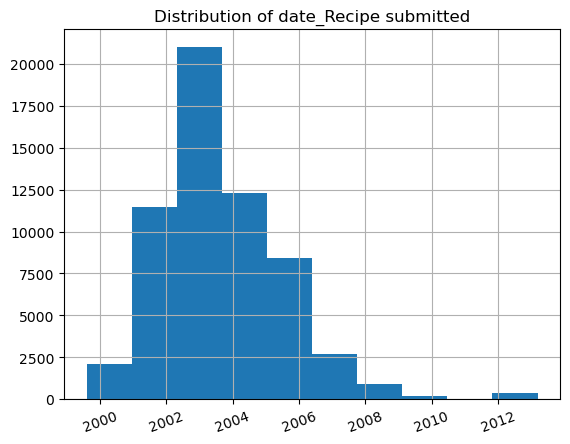

In [222]:
custrecipe_filter["date_Recipe"].hist(xrot=20)
plt.title("Distribution of date_Recipe submitted")
plt.show()

In [223]:
# Find median date for 
print(custrecipe_filter['date_Reviewed'].median())
#2008-06-13 for User based
# 2008-07-16 for custrecipe_filter
print(custrecipe_filter['date_Recipe'].median())
#2004-04-16 for User based
# 2003-04-03 for custrecipe_filter

2008-07-16 00:00:00
2003-04-03 00:00:00


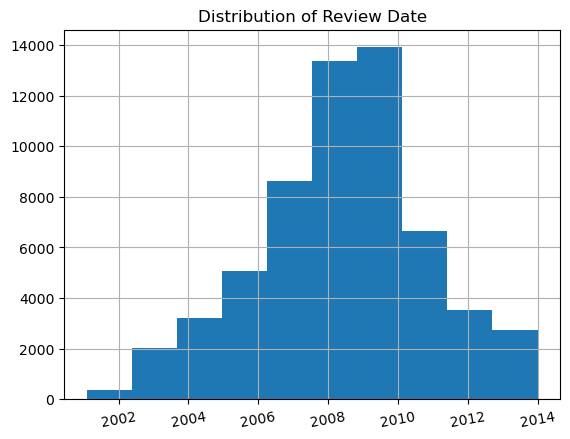

In [224]:
custrecipe_filter["date_Reviewed"].hist(xrot=10)
plt.title("Distribution of Review Date")
plt.show()

In [225]:
custrecipe_filter["date_Reviewed"].describe()

count                            59446
mean     2008-05-29 20:24:33.283315968
min                2001-02-01 00:00:00
25%                2007-01-03 00:00:00
50%                2008-07-16 00:00:00
75%                2009-12-16 00:00:00
max                2013-12-31 00:00:00
Name: date_Reviewed, dtype: object

In [226]:
custrecipe_filter["date_Recipe"].describe()

count                            59446
mean     2003-08-21 17:35:34.226020352
min                1999-08-09 00:00:00
25%                2002-05-13 00:00:00
50%                2003-04-03 00:00:00
75%                2004-09-22 00:00:00
max                2013-03-11 00:00:00
Name: date_Recipe, dtype: object

In [227]:
np.mean(custrecipe_filter.groupby(['recipe_id']).count()['user_id'])

25.050990307627476

In [228]:
np.mean(custrecipe_filter.groupby(['user_id']).count()['recipe_id'])

5.48546645750669

In [229]:
custrecipe_filter

,name,id,minutes,contributor_id,date_Recipe,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id,recipe_id,date_Reviewed,rating,review,merged_id,name_
0,potato crab chowder,R7175168,45,U2898859,2003-12-18,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'o...","[274.2, 12.0, 15.0, 18.0, 32.0, 22.0, 12.0]",8,"['saute onion& garlic in melted butter in large sauce pan for 4 minutes', 'add potato and saute ...",soup for the soul!,"['butter', 'onion', 'garlic', 'potatoes', 'flour', 'milk', 'black pepper', 'nutmeg', 'creamed co...",13,U6399349,R7175168,2006-11-11,6,"Oh, This was wonderful! Had a soup and salad dinner and most people barely ate salad, LOL. Thi...",R7175168_U6399349,0
1,potato crab chowder,R7175168,45,U2898859,2003-12-18,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'o...","[274.2, 12.0, 15.0, 18.0, 32.0, 22.0, 12.0]",8,"['saute onion& garlic in melted butter in large sauce pan for 4 minutes', 'add potato and saute ...",soup for the soul!,"['butter', 'onion', 'garlic', 'potatoes', 'flour', 'milk', 'black pepper', 'nutmeg', 'creamed co...",13,U8577633,R7175168,2006-02-13,6,Wow! My family loves this recipe and it is a great winter meal. I do have to say that I adjust...,R7175168_U8577633,0
2,potato crab chowder,R7175168,45,U2898859,2003-12-18,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'o...","[274.2, 12.0, 15.0, 18.0, 32.0, 22.0, 12.0]",8,"['saute onion& garlic in melted butter in large sauce pan for 4 minutes', 'add potato and saute ...",soup for the soul!,"['butter', 'onion', 'garlic', 'potatoes', 'flour', 'milk', 'black pepper', 'nutmeg', 'creamed co...",13,U5202646,R7175168,2006-03-21,6,"Excellent chowder. This was the perfect warm-up at the end of a cold, snowy day. I used more c...",R7175168_U5202646,0
3,potato crab chowder,R7175168,45,U2898859,2003-12-18,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'o...","[274.2, 12.0, 15.0, 18.0, 32.0, 22.0, 12.0]",8,"['saute onion& garlic in melted butter in large sauce pan for 4 minutes', 'add potato and saute ...",soup for the soul!,"['butter', 'onion', 'garlic', 'potatoes', 'flour', 'milk', 'black pepper', 'nutmeg', 'creamed co...",13,U3028804,R7175168,2008-02-01,5,"Oh, how wonderful! I doubled the crab, and added some carrots (and some extra broth to compensa...",R7175168_U3028804,0
4,potato crab chowder,R7175168,45,U2898859,2003-12-18,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'o...","[274.2, 12.0, 15.0, 18.0, 32.0, 22.0, 12.0]",8,"['saute onion& garlic in melted butter in large sauce pan for 4 minutes', 'add potato and saute ...",soup for the soul!,"['butter', 'onion', 'garlic', 'potatoes', 'flour', 'milk', 'black pepper', 'nutmeg', 'creamed co...",13,U4346402,R7175168,2008-03-07,5,DH and I enjoyed this. However I used it only as a base for a potato/seafood chowder. I made as ...,R7175168_U4346402,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59441,quick yellow cake,R8199809,42,U2559031,2002-09-02,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'occasion', 'desserts', 'oven', ...","[264.7, 15.0, 89.0, 12.0, 7.0, 14.0, 13.0]",6,"['heat oven to 350', 'mix dry ingredients in lg bowl', 'add shortening , milk and vanilla', 'bea...",you can mix this up in a hurry.,"['flour', 'sugar', 'baking powder', 'salt', 'shortening', 'milk', 'vanilla', 'eggs']",8,U8035759,R8199809,2009-02-15,5,"This cake was good, but it tasted more like a poundcake than a traditional yellow cake. Not quit...",R8199809_U8035759,2371
59442,quick yellow cake,R8199809,42,U2559031,2002-09-02,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'occasion', 'desserts', 'oven', ...","[264.7, 15.0, 89.0, 12.0, 7.0, 14.0, 13.0]",6,"['heat oven to 350', 'mix dry ingredients in lg bowl'

## Calories variable

In [233]:
# Split the 'nutrition' column on comma and expand the split strings into separate columns
split_data = custrecipe_filter['nutrition'].str.split(',', expand=True)
split_data
split_data[0]
# # Create a new 'calories' column with the first set of numbers (which is the first column after the split)
# custrecipe_filter['calories'] = split_data[0]

# # If the calories values are not numeric (e.g., they're still strings), convert them to numeric values
# custrecipe_filter['calories'] = pd.to_numeric(custrecipe_filter['calories'], errors='coerce')


0        [274.2
1        [274.2
2        [274.2
3        [274.2
4        [274.2
          ...  
59441    [264.7
59442    [264.7
59443    [264.7
59444    [264.7
59445    [264.7
Name: 0, Length: 59446, dtype: object

In [194]:
## Food types, veg/non veg variable

In [195]:
custrecipe_filter['food_ty'] = np.nan
custrecipe_filter['food_ty'] = custrecipe_filter['food_ty'].astype('str')

In [231]:
custrecipe_filter['ingredients']

0        ['butter', 'onion', 'garlic', 'potatoes', 'flour', 'milk', 'black pepper', 'nutmeg', 'creamed co...
1        ['butter', 'onion', 'garlic', 'potatoes', 'flour', 'milk', 'black pepper', 'nutmeg', 'creamed co...
2        ['butter', 'onion', 'garlic', 'potatoes', 'flour', 'milk', 'black pepper', 'nutmeg', 'creamed co...
3        ['butter', 'onion', 'garlic', 'potatoes', 'flour', 'milk', 'black pepper', 'nutmeg', 'creamed co...
4        ['butter', 'onion', 'garlic', 'potatoes', 'flour', 'milk', 'black pepper', 'nutmeg', 'creamed co...
                                                        ...                                                 
59441                   ['flour', 'sugar', 'baking powder', 'salt', 'shortening', 'milk', 'vanilla', 'eggs']
59442                   ['flour', 'sugar', 'baking powder', 'salt', 'shortening', 'milk', 'vanilla', 'eggs']
59443                   ['flour', 'sugar', 'baking powder', 'salt', 'shortening', 'milk', 'vanilla', 'eggs']
59444              

In [197]:
for i in custrecipe_filter['ingredients'].index:
    if 'eggs' not in custrecipe_filter['ingredients'][i]:
        if 'ice-cream' in custrecipe_filter['ingredients'][i] or 'chocolate' in custrecipe_filter['ingredients'][i] or 'cookies' in custrecipe_filter['ingredients'][i]:
            custrecipe_filter['food_ty'][i] = 'Veg dessert'
    elif 'eggs' in custrecipe_filter['ingredients'][i]:
        if 'ice-cream' in custrecipe_filter['ingredients'][i] or 'chocolate' in custrecipe_filter['ingredients'][i] or 'cookies' in custrecipe_filter['ingredients'][i]:
            custrecipe_filter['food_ty'][i] = 'Non-Veg dessert'

C:\Users\Source\AppData\Local\Temp\ipykernel_24032\1580618742.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  custrecipe_filter['food_ty'][i] = 'Veg dessert'
C:\Users\Source\AppData\Local\Temp\ipykernel_24032\1580618742.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  custrecipe_filter['food_ty'][i] = 'Veg dessert'
C:\Users\Source\AppData\Local\Temp\ipykernel_24032\1580618742.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c

In [198]:
for i in custrecipe_filter.index:
    if(custrecipe_filter['food_ty'][i]!='Veg dessert' and custrecipe_filter['food_ty'][i]!='Non-Veg dessert' and 20<custrecipe_filter['calories'][i]<300):
        custrecipe_filter['food_ty'][i]='Healthy'

In [200]:
custrecipe_filter

,name,id,minutes,contributor_id,date_Recipe,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id,recipe_id,date_Reviewed,rating,review,merged_id,name_,calories,food_ty
0,potato crab chowder,R7175168,45,U2898859,2003-12-18,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'o...","[274.2, 12.0, 15.0, 18.0, 32.0, 22.0, 12.0]",8,"['saute onion& garlic in melted butter in large sauce pan for 4 minutes', 'add potato and saute ...",soup for the soul!,"['butter', 'onion', 'garlic', 'potatoes', 'flour', 'milk', 'black pepper', 'nutmeg', 'creamed co...",13,U6399349,R7175168,2006-11-11,6,"Oh, This was wonderful! Had a soup and salad dinner and most people barely ate salad, LOL. Thi...",R7175168_U6399349,0,NaN,nan
1,potato crab chowder,R7175168,45,U2898859,2003-12-18,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'o...","[274.2, 12.0, 15.0, 18.0, 32.0, 22.0, 12.0]",8,"['saute onion& garlic in melted butter in large sauce pan for 4 minutes', 'add potato and saute ...",soup for the soul!,"['butter', 'onion', 'garlic', 'potatoes', 'flour', 'milk', 'black pepper', 'nutmeg', 'creamed co...",13,U8577633,R7175168,2006-02-13,6,Wow! My family loves this recipe and it is a great winter meal. I do have to say that I adjust...,R7175168_U8577633,0,NaN,nan
2,potato crab chowder,R7175168,45,U2898859,2003-12-18,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'o...","[274.2, 12.0, 15.0, 18.0, 32.0, 22.0, 12.0]",8,"['saute onion& garlic in melted butter in large sauce pan for 4 minutes', 'add potato and saute ...",soup for the soul!,"['butter', 'onion', 'garlic', 'potatoes', 'flour', 'milk', 'black pepper', 'nutmeg', 'creamed co...",13,U5202646,R7175168,2006-03-21,6,"Excellent chowder. This was the perfect warm-up at the end of a cold, snowy day. I used more c...",R7175168_U5202646,0,NaN,nan
3,potato crab chowder,R7175168,45,U2898859,2003-12-18,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'o...","[274.2, 12.0, 15.0, 18.0, 32.0, 22.0, 12.0]",8,"['saute onion& garlic in melted butter in large sauce pan for 4 minutes', 'add potato and saute ...",soup for the soul!,"['butter', 'onion', 'garlic', 'potatoes', 'flour', 'milk', 'black pepper', 'nutmeg', 'creamed co...",13,U3028804,R7175168,2008-02-01,5,"Oh, how wonderful! I doubled the crab, and added some carrots (and some extra broth to compensa...",R7175168_U3028804,0,NaN,nan
4,potato crab chowder,R7175168,45,U2898859,2003-12-18,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'o...","[274.2, 12.0, 15.0, 18.0, 32.0, 22.0, 12.0]",8,"['saute onion& garlic in melted butter in large sauce pan for 4 minutes', 'add potato and saute ...",soup for the soul!,"['butter', 'onion', 'garlic', 'potatoes', 'flour', 'milk', 'black pepper', 'nutmeg', 'creamed co...",13,U4346402,R7175168,2008-03-07,5,DH and I enjoyed this. However I used it only as a base for a potato/seafood chowder. I made as ...,R7175168_U4346402,0,NaN,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59441,quick yellow cake,R8199809,42,U2559031,2002-09-02,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'occasion', 'desserts', 'oven', ...","[264.7, 15.0, 89.0, 12.0, 7.0, 14.0, 13.0]",6,"['heat oven to 350', 'mix dry ingredients in lg bowl', 'add shortening , milk and vanilla', 'bea...",you can mix this up in a hurry.,"['flour', 'sugar', 'baking powder', 'salt', 'shortening', 'milk', 'vanilla', 'eggs']",8,U8035759,R8199809,2009-02-15,5,"This cake was good, but it tasted more like a poundcake than a traditional yellow cake. Not quit...",R8199809_U8035759,2371,NaN,nan
59442,quick yellow cake,R8199809,42,U2559031,2002-09-02,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'occasion', 'desserts', 'oven', ...","[264.7, 15.0, 89.0, 12.0, 7

## Train & test split

For the collaborative filtering solution, is based on user-item interactions (in this case, user reviews of recipes), 
we split the data based on a cutoff date. 
The idea behind this approach is to simulate a real-world scenario where the model is trained on historical data (reviews before the cutoff date) and then evaluated on its ability to predict future interactions (reviews after the cutoff date).

In [ ]:

cutoff_date = "2009-01-01" 

train = custrecipe_filter[custrecipe_filter['date_Reviewed'] < cutoff_date].reset_index(drop=True)
test = custrecipe_filter[custrecipe_filter['date_Reviewed'] >= cutoff_date].reset_index(drop=True)

In [ ]:
pd.DataFrame({'Type':train.dtypes, 'Missing':train.isna().sum(), "Cnt_unique":train.nunique()})

In [ ]:
# filter columns
filter_cols = ["user_id", "recipe_id", "rating"]

train = train[filter_cols]
test = test[filter_cols]

In [ ]:
# set up reader with min rating and max rating as arguments
reader = Reader(rating_scale=(1, 6))

# surprise training and test set
df_train = Dataset.load_from_df(train, reader).build_full_trainset()
df_test = list(test.itertuples(index=False, name=None))

## Fit user-based surprise.KNNBasic using cosine similarity

cosine similarity is a measure of similarity between two non-zero vectors
it is slow for large datasets because it requires comparing each user to every other user
so we have to subset or sample

In [ ]:


# set option to cosine similarity and user-based collaborative filtering
options = {'name':'cosine', 'user_based':True}

# select 20 most similar users (min 5)
ub = KNNBasic(k=20, min_k=5, sim_options=options, random_state=42)

# fit on training set
ub.fit(df_train)

In [ ]:
pred = ub.test(df_test)
accuracy.rmse(pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in pred if i.details["was_impossible"]]) / len(pred)
print(f"Impossible: {perc_impossible:.4f}")

In [ ]:
ub.default_prediction()

## Fit user-based surprise.KNNBasic using pearson correlation

measures the linear correlation between two variables.
not good at predictions if there’s not enough data on similar users or items.

In [ ]:
# set option to cosine similarity and user-based collaborative filtering
options = {'name':'pearson', 'user_based':True}

# select 20 most similar items (min 5)
ib = KNNBasic(k=10, min_k=2, sim_options=options, random_state=42)

# fit on training set
ib.fit(df_train)

In [ ]:
pred = ib.test(df_test)
accuracy.rmse(pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in pred if i.details["was_impossible"]]) / len(pred)
print(f"Impossible: {perc_impossible:.4f}")

In [ ]:
ib.default_prediction()

## Fit an ALS 

ALS can handle sparse data and is relatively efficient
It works by fixing one factor matrix and solving for the other, 

In [ ]:
# Select alternating least squares (ALS) and 30 epochs
options = {"method": "als", "n_epochs": 50}
als = BaselineOnly(bsl_options=options)

# fit on training set
als.fit(df_train)

pred = als.test(df_test)
accuracy.rmse(pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in pred if i.details["was_impossible"]]) / len(pred)
print(f"Impossible: {perc_impossible:.4f}")

Increased the als epoch to 50 from 30 and the RMSE improves by 0.2

## Fit and SVD (surprise.SVD)

In [ ]:
# select 20 factors and use probabilistic matrix factorization (no bias)
svd = SVD(n_factors=20, biased=False, random_state=42)

# fit on training set
svd.fit(df_train)

pred = svd.test(df_test)
accuracy.rmse(pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in pred if i.details["was_impossible"]]) / len(pred)
print(f"Impossible: {perc_impossible:.4f}")

In [ ]:
print(als.default_prediction())
print(svd.default_prediction())

## Fit a CoClustering 

In [ ]:
clust = CoClustering(n_cltr_u=10, n_cltr_i=10, n_epochs=50, random_state=42)

clust.fit(df_train)
pred = clust.test(df_test)
accuracy.rmse(pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in pred if i.details["was_impossible"]]) / len(pred)
print(f"Impossible: {perc_impossible:.4f}")

Impossible =  No issues were face when generated predictions 

In [ ]:
clust.default_prediction()

default_prediction is the average rating predicted by the model for all instances when no specific prediction can be made

## Display the top 3 recommendations for a user

In [ ]:
import random
random.choice(train['user_id'])#R140404

In [ ]:
robert_rows = train[train['user_id'].str.contains('U716504', na=False)]
robert_rows

In [ ]:
def predict_user_topn(model, train, user, topk=15, item_col='item'):
    """
    Returns topk items for specified user.
    Return type: list

    Args[model, train, user, topk, item_col]
    model:      fitted model (surprise package)
    train:      train set used to fit model
    user:       user id
    topk:       topk items to return
    item_col:   column containing item ids 
    """

    # intermediate result dict 
    res = {item_col:[], 'pred':[], 'detail':[]}
    
    # iter through all items contained in train set
    for item in set(train[item_col]) :
        uid, iid, true_r, est, detail = model.predict(user,item)
        # if detail['was_impossible']: continue
        # save to result dict
        res[item_col].append(item)
        res['pred'].append(est)
        res['detail'].append(detail)

    return list(pd.DataFrame(res).sort_values('pred', ascending=False)[:topk][item_col])

In [ ]:
# Top 3 recommendations for user "U716504"

user = "U716504"
topk = 3

res = {}
for model_name, model in dict(user_based=ub, item_based=ib, als=als, svd=svd, coclustering=clust).items():
    pred = predict_user_topn(model, train, user=user, topk=topk, item_col="recipe_id")

    # Get name for each of the predicted recipe IDs
    pred_name = [lookup_recipe_id.loc[i]["name"] for i in pred]

    res[model_name] = pred_name

### Reccomendation predict

In [ ]:
pd.DataFrame(res)

# Conent Based

## Pre-Processing : Checking Type, missing values and unique counts

In [ ]:
pd.DataFrame({'Type':user_recipe.dtypes, 'Missing':user_recipe.isna().sum(), "Cnt_unique":user_recipe.nunique()})

Viewing all recipe_id that has notna

## Merged_ID for id and user_id

In [ ]:
user_recipe['merged_id'] = user_recipe['id'].astype(str) +'_' +user_recipe['user_id'].astype(str)

### custrecipe_filter_sample variable

Rename column to default 

In [ ]:
custrecipe_filter_sample = user_recipe.sample(n=30000, random_state=127)


In [ ]:
custrecipe_filter_sample.minutes.describe()

In [ ]:
data = custrecipe_filter_sample[['user_id', 'recipe_id', 'rating', 'tags', 'minutes','steps', 'n_ingredients', 'n_steps']]
data = data.rename(columns={'user_id': 'user', 'recipe_id': 'item'})
data

In [ ]:
data.head()

In [ ]:
data.user.nunique()

## Creating Features

In [ ]:
data.isna().sum()

## 1) prep_time categorizing minutes features

In [ ]:
# Define the bins for categorizing minutes
bins = [-1, 25, 70, 200, float('inf')]
labels = ['short_prep', 'avg_prep', 'long_prep', 'extremely_long_prep']

# Create a new variable based on the length of minutes
data['prep_time'] = pd.cut(data['minutes'], bins=bins, labels=labels)

# Display the counts of each category
print(data['prep_time'].value_counts())


In [ ]:
data

In [ ]:
content_data = data[['prep_time','item']]
# Rename the 'item' column to 'id'
content_data.rename(columns={'item': 'id'}, inplace=True)

### One-hot encode the 'prep_time' column

In [ ]:
# One-hot encode the 'prep_time' column
prep_time_dummies = pd.get_dummies(content_data['prep_time'], prefix='prep_time')
prep_time_dummies = prep_time_dummies.apply(lambda x: x.astype(int))

# Concatenate the one-hot encoded DataFrame with the original DataFrame, keeping the 'data.id' column
content_data = pd.concat([content_data[['id']], prep_time_dummies], axis=1)

content_data

## 2) Ingredients Features
## content_data with user

In [ ]:
content_data = pd.concat([content_data, custrecipe_filter_sample['ingredients']], axis=1)
content_data

In [ ]:
content_data

In [ ]:
# Convert the ingredients column from string to list if it's not already a list
import ast
if custrecipe_filter_sample['ingredients'].apply(lambda x: isinstance(x, str)).any():
    custrecipe_filter_sample['ingredients'] = custrecipe_filter_sample['ingredients'].apply(ast.literal_eval)

# Explode the ingredients column into separate rows
exploded_df = custrecipe_filter_sample.explode('ingredients')

# Count the frequency of each ingredient per id
ingredient_counts = exploded_df.groupby('id')['ingredients'].value_counts()
ingredient_counts

In [ ]:
ingredient_counts

In [ ]:
ingredient_counts_df = ingredient_counts.reset_index(name='ing_counts')
ingredient_counts_df

### ingredient_counts_df features with id

In [ ]:
# Find the top 10 most common ingredients
top_ingredients = ingredient_counts_df['ingredients'].value_counts().head(10).index

# Replace all other ingredients with 'other'
ingredient_counts_df['ingredients'] = ingredient_counts_df['ingredients'].apply(lambda x: x if x in top_ingredients else 'other')

# One-hot encode the 'ingredients' column
ingredient_dummies = pd.get_dummies(ingredient_counts_df['ingredients'], prefix='ingredient')

# One-hot encode the 'counts' column
counts_dummies = pd.get_dummies(ingredient_counts_df['ing_counts'], prefix='count')

# Concatenate the one-hot encoded columns with the original DataFrame
ingredient_counts_df = pd.concat([ingredient_counts_df[['id']], ingredient_dummies, counts_dummies], axis=1)

# Convert all columns except 'id' to integers
ingredient_counts_df.iloc[:, 1:] = ingredient_counts_df.iloc[:, 1:].applymap(int)
ingredient_counts_df

## Merge features content_data

In [ ]:
# Merge ingredient_counts_df with content_data on the 'id' column
content_data = content_data.merge(ingredient_counts_df, on='id', how='left')

In [ ]:
content_data.columns

In [ ]:
content_data

columns_to_drop = ['ingredients']
content_data = content_data.drop(columns=columns_to_drop)

In [ ]:
# Remove 'R' string and convert to int64
# data['item'] = data['item'].str.replace('R', '').astype('int64')
# data['user'] = data['user'].str.replace('U', '').astype('int64')
data

In [ ]:
print(data.shape)
print(data.columns)

In [ ]:
print(metadata.columns)
print(metadata.dtypes)

## 3) feature total_chars_D tag_count_T

### Check for missing values in the description column

total_chars_ofdescription & tag_count_oftags

In [ ]:
# Check for missing values in the description column
metadata_Dis_tag =  metadata[['id','description','tags']]
missing_values = metadata_Dis_tag['description'].isnull().sum()
if missing_values > 0:
    print("There are missing values in the description column. Handling them...")

    # Fill missing values with an empty string
    metadata_Dis_tag['description'].fillna('', inplace=True)

# Now create the total_chars feature
metadata_Dis_tag['total_chars_D'] = metadata_Dis_tag['description'].apply(len)  # Total characters in description
metadata_Dis_tag['tag_count_T'] = metadata_Dis_tag['tags'].apply(lambda x: len(x.split(',')))  # Number of tags


# Convert to int64
metadata_Dis_tag['total_chars_D'] = metadata_Dis_tag['total_chars_D'].astype('int64')
metadata_Dis_tag['tag_count_T'] = metadata_Dis_tag['tag_count_T'].astype('int64')
metadata_Dis_tag

In [ ]:
metadata_Dis_tag.total_chars_D.describe()

In [ ]:
# Define the bins for categorizing total_chars_D
bins = [-1, 0, 80, 260, float('inf')]
labels = ['no_descrip', 'short_descrip', 'avg_descrip', 'long_descrip']

# Create a new variable based on the length of total_chars_D
metadata_Dis_tag['description_length'] = pd.cut(metadata_Dis_tag['total_chars_D'], bins=bins, labels=labels)

# Display the counts of each category
print(metadata_Dis_tag['description_length'].value_counts())

# One-hot encode the 'description_length' column
description_length_dummies = pd.get_dummies(metadata_Dis_tag['description_length'], prefix='description_length')
description_length_dummies = description_length_dummies.apply(lambda x: x.astype(int))

# Concatenate the one-hot encoded DataFrame with the original DataFrame, keeping the 'id' column
metadata_Dis_tag = pd.concat([metadata_Dis_tag[['id']], description_length_dummies], axis=1)
metadata_Dis_tag

### Merge metadata_Dis_tag with content_data on the 'id' column

In [ ]:
content_data = content_data.merge(metadata_Dis_tag, on='id', how='left')
content_data

## 4) Features Tags one hot encoding

In [ ]:
# Step 1: Split the comma-separated values in the 'tags' column
data.loc[:, 'tags'] = data['tags'].apply(lambda x: [tag.strip().strip("'\"") for tag in x.strip('[]').split(',')] if isinstance(x, str) else [])

# Step 2: Extract unique tags
unique_tags = set(tag for tags_list in data['tags'] for tag in tags_list)

# Step 3: Create new binary columns for each unique tag and assign values
for tag in unique_tags: 
    data.loc[:, tag] = data['tags'].apply(lambda x: 1 if tag in x else 0)

# Create a copy of the DataFrame with the additional columns
data_with_tags = data[['item'] + list(unique_tags)]
data_with_tags

In [ ]:
content_data = content_data.merge(data_with_tags, left_on='id',right_on='item', how='left')

In [ ]:
content_data

In [ ]:
content_data.columns

## Drop Columns

In [ ]:
# columns_to_drop = ['item', 'rating', 'tags', 'minutes', 'steps','n_ingredients','n_steps' ]
# data = data.drop(columns=columns_to_drop)

In [ ]:
data.shape

In [ ]:
content_data = content_data.groupby('id').last()
content_data

In [ ]:
content_data

## Change to INT

In [ ]:
# Convert columns to integer type
data_index = content_data.copy()
columns_to_drop = ['item']
data_index = data_index.drop(columns=columns_to_drop)
data_index

In [ ]:
data_index = data_index.astype({col: int for col in data_index.columns if col != 'index'})

In [ ]:
data_index

## Train & Test Conent based

In [ ]:
data_index.head()

In [ ]:
print(train.shape)

In [ ]:
custrecipe_filter_sample

In [ ]:
columns = ['user_id', 'recipe_id', 'rating']
train = custrecipe_filter_sample[columns]
print(train.head())


In [ ]:
train = train.rename(columns={'user_id': 'user', 'recipe_id': 'item'})
train.head()


In [ ]:
# train-test split
train, test = train_test_split(train, test_size=0.3, random_state=127)

# reset index
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print(data_index.shape)
print(train.shape)
print(test.shape)

In [ ]:
reader = Reader(rating_scale=(1, 6))
df_train = Dataset.load_from_df(train, reader).build_full_trainset()
df_test = list(test.itertuples(index=False, name=None))

# Results

In [ ]:
# Model dictionary
model_dict = {
    'user_based_cosine': ub,
    'als': als,
    'svd': svd,
    'coclustering': clust
}

overview = pd.concat([eval.evaluate(mod.fit(df_train).test(df_test), topn=5, rating_cutoff=4) for mod in model_dict.values()], axis=1)
overview.columns = list(model_dict.keys())
overview

ALS and user-based cosine similarity models perform similarly and have the lowest RMSE values, indicating better accuracy.

In [ ]:
df_train

I keep getting this erro AttributeError: 'CoClustering' object has no attribute 'ContentBased'
And only way is to load the packages again

In [ ]:
# !pip install --upgrade ieseg_recsys.model.ContentBased.

In [ ]:
# And only way is to load the packages again
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import os
import numpy as np
from collections import Counter

from surprise import Dataset, Reader, KNNBasic, accuracy
from ieseg_recsys import eval, model
from sklearn.model_selection import train_test_split
from scipy import sparse
from surprise import SVD, CoClustering

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, KNNBasic, SVD


## fit and predict

In [ ]:
# init content-based
cb = model.ContentBased(NN=10)

# fit on content
cb.fit(data_index)

# fit on train_ratings
cb.fit_ratings(df_train)

# predict test ratings
cb_pred = cb.test(df_test)

#AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
# compute metrics
cb_res = eval.evaluate(cb_pred, topn=5, rating_cutoff=4).rename(columns={'value':'Content_based_10'})
cb_res

In [ ]:
overview = pd.concat([overview, cb_res], axis=1)
overview

The lowest RMSE is the Alternating Least Squares (ALS) model, with an RMSE of approximately 1.075162. 
Therefore, based on the RMSE metric alone, the ALS model performs the best

# Exporting the files

In [ ]:
# id -> user_id, recipe_id
submission = pd.read_csv(r"C:\K10\IESEG\Studies\2024\SEM_2\Recommender Systems\Untitled Folder\recommender_systems_2024\sample_submission.csv")
submission[["user_id", "recipe_id"]] = submission["id"].str.split("_", expand=True)
submission = submission.drop('rating', axis=1)
submission

In [ ]:
def get_rating(model, user, item):
    _, _, _, est, _ = model.predict(user, item)
    return est

In [ ]:
# Model dictionary
model_dict = {
    # 'user_based': ub,
    # 'item_based': ib,
    # 'als': als,
    # 'als_with_H-P Tuning & C-V': als_best_algo,
    # 'svd': svd,
    # 'svd_with_H-P Tuning & C-V': svd_best_algo,
    # 'coclustering': clust
}

# Iterate through each model
for model_name, model in model_dict.items():
    # Apply the model to get ratings
    submission[model_name + '_rating'] = submission.apply(lambda row: get_rating(model, row['user_id'], row['recipe_id']), axis=1)
    
    # Create the 'id' column by combining 'user_id' and 'recipe_id'
    submission['id'] = submission['user_id'] + '_' + submission['recipe_id']
    
    # Create a new DataFrame with the 'id' and model-specific rating column, then rename the rating column
    output_df = submission[['id', model_name + '_rating']].rename(columns={model_name + '_rating': 'rating'})
    
    # Save to CSV, using the model name to label each file
    output_file_name = model_name + '.csv'
    output_df.to_csv(output_file_name, index=False)
    print(f"Saved {output_file_name}")